# Comparing KNN to OLS Regression Models

In this notebook, we will be comparing the performance of two types of regression models on the same dataset. This will include Feature Engineering and Selection, Model Building, Evaluation, and Iteration.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [4]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [5]:
# Rename columns to work with statsmodel formula, set Customer ID as index
df = df.rename({'Annual Income (k$)': 'AnnualIncome', 'Spending Score (1-100)': 'SpendingScore'}, axis=1)
df = df.set_index('CustomerID')

In [6]:
from scipy.stats import boxcox

# Create a column for the age groups divided into quintiles
#df['Generation'] = pd.qcut(df['Age'], 5, labels=False)
#df['Generation'] = df['Generation'].apply(lambda x: x+1)

df['Female'] = df['Gender'].apply(lambda x: 1 if x=='Female' else 0)

# Transform Annual Income to have a more linear relationship to Spending Score
df['AnnualIncome'] = df['AnnualIncome'].apply(lambda x: np.log(x))

# Transform Age to create more linear relationship to Spending Score 
df['Age'] = df['Age'].apply(lambda x: 1/x)

# Create a column for the interaction between generation and income, transform for more linear relationship
df['GenIncome'] = df['Age'] * df['AnnualIncome']
df['GenIncome'] = df['GenIncome'].apply(lambda x: np.sqrt(x))

df = df[['Gender', 'Age', 'AnnualIncome', 'GenIncome', 'Female', 'SpendingScore']]

df.head()

,Gender,Age,AnnualIncome,GenIncome,Female,SpendingScore
CustomerID,,,,,,
1,Male,0.052632,2.708050,0.377530,0,39
2,Male,0.047619,2.708050,0.359103,0,81
3,Female,0.050000,2.772589,0.372330,1,6
4,Female,0.043478,2.772589,0.347199,1,77
5,Female,0.032258,2.833213,0.302314,1,40


In [7]:
# Scale the independent variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['Age', 'AnnualIncome', 'GenIncome', 'SpendingScore']] = scaler.fit_transform(
    df[['Age', 'AnnualIncome', 'GenIncome', 'SpendingScore']])

C:\Users\Jeff\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jeff\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


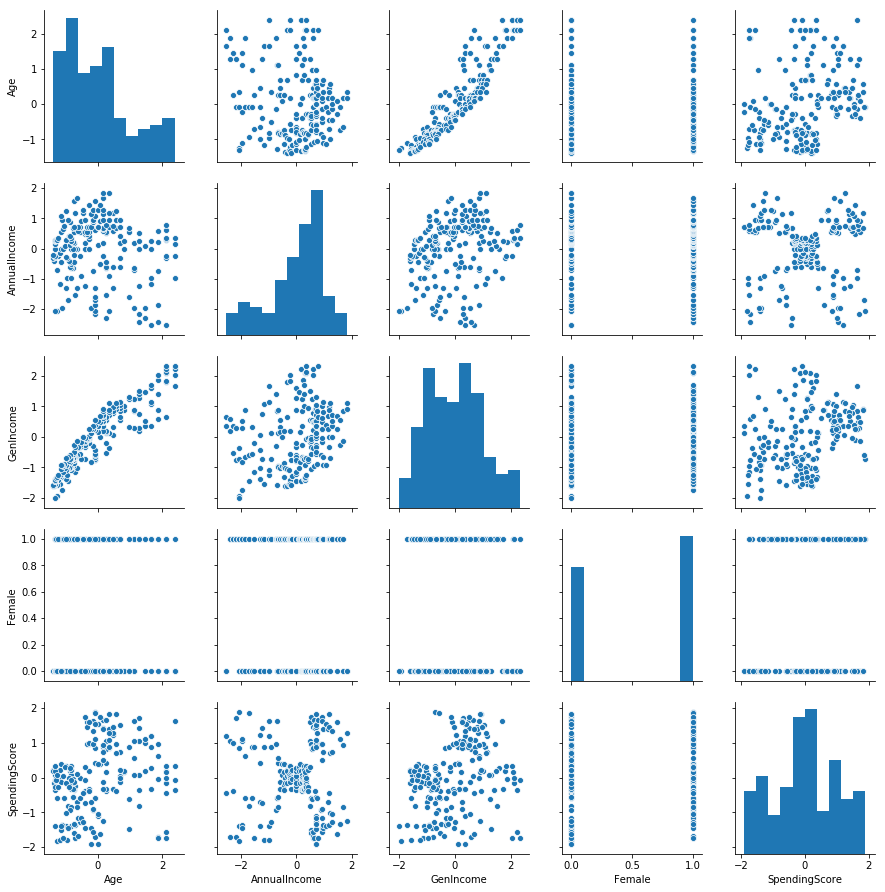

In [8]:
# Check the linear relationships of the variables
sns.pairplot(df.iloc[:, 1:])
plt.show()

## Assumption of Linear Relationship

Looking at the relationships between the independent variables and the outcome variable, this assumption is not being met. Though I have tried several transformations (root, power, inverse, log, boxcox), none seem to bring the variables into a truly linear relationship. For this reason, we can assume these models will perform poorly and this dataset may be better suited to a categorical classifier if there is indeed any relationship between the independent and outcome variables.

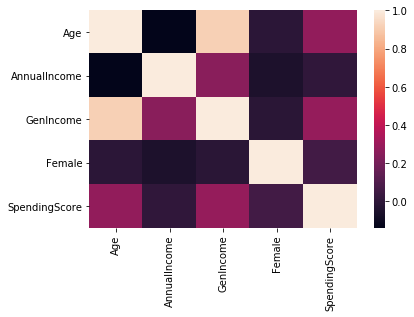

In [9]:
sns.heatmap(df.corr())
plt.show()

## Assumption of Low Multicollinearity

Generational Income will be collinear with Age and Income because it is an interaction of those two variables. Generation and Age are also collinear because one is an interpolation of the other. I added Generational Income because I thought the interaction between age group and disposible income would create a theoretically sound indicator of mall spending. This could be confounded, however by the frequency of trips to the mall for younger generations, where they might only spend signifcantly on 10% of their trips whereas the other 90% are purely social. I intend to determine which measures of age and income describe the most variance in the outcome variable and keep only those.


In [10]:
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import neighbors
from sklearn.model_selection import cross_val_score

In [11]:
# Create an ordinary least squares regression model for the features and evaluate the performance
linear_formula = 'SpendingScore ~ GenIncome+Age+AnnualIncome+Female'
lm = smf.ols(formula=linear_formula, data=df).fit()
print('\nCoefficients: \n', lm.params)
print('P-Values:\n{}'.format(lm.pvalues))
print('Model 1 R-Squared: {}'.format(lm.rsquared))


Coefficients: 
 Intercept      -0.050060
GenIncome       1.077091
Age            -0.761580
AnnualIncome   -0.367625
Female          0.089393
dtype: float64
P-Values:
Intercept       0.628904
GenIncome       0.087698
Age             0.215655
AnnualIncome    0.148303
Female          0.520994
dtype: float64
Model 1 R-Squared: 0.09626021368167936


In [26]:
# Create a weighted KNN model for the features and cross-validate 
knn_w = neighbors.KNeighborsRegressor(n_neighbors=21, weights='distance')
X = df[['GenIncome', 'Age', 'AnnualIncome', 'Female']]
Y = df['SpendingScore']
knn_w.fit(X, Y)

score = cross_val_score(knn_w, X, Y, cv=5, scoring='r2')
print('Weighted Accuracy: {:0.2f}  (+/-{:0.2f})'.format(score.mean(), score.std()))

Weighted Accuracy: -0.34  (+/-0.87)


In [27]:
# Create an unweighted KNN model for the features and cross-validate 
knn = neighbors.KNeighborsRegressor(n_neighbors=21)
X = df[['GenIncome', 'Age', 'AnnualIncome', 'Female']]
Y = df['SpendingScore']
knn.fit(X, Y)

score = cross_val_score(knn, X, Y, cv=5, scoring='r2')
print('Unweighted Accuracy: {:0.2f}  (+/-{:0.2f})'.format(score.mean(), score.std()))

Unweighted Accuracy: -0.46  (+/-0.98)


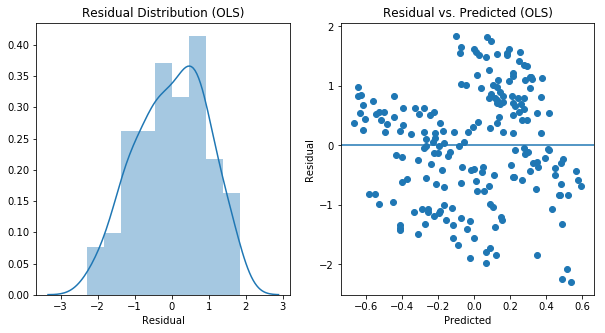

In [14]:
# Plot the residual distribution and the residual vs. predicted to check for error normality and homoscedasticity
ols_preds = lm.predict(X).ravel()
residual = Y - ols_preds

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.distplot(residual)
plt.title('Residual Distribution (OLS)')
plt.xlabel('Residual')

plt.subplot(1,2,2)
plt.scatter(ols_preds, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted (OLS)')

plt.show()

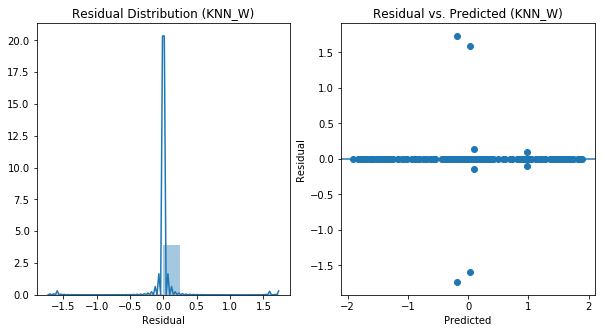

In [15]:
# Plot the residual distribution and the residual vs. predicted to check for error normality and homoscedasticity
knnw_preds = knn_w.predict(X).ravel()
residual = Y - knnw_preds

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.distplot(residual)
plt.title('Residual Distribution (KNN_W)')
plt.xlabel('Residual')

plt.subplot(1,2,2)
plt.scatter(knnw_preds, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted (KNN_W)')
plt.show()

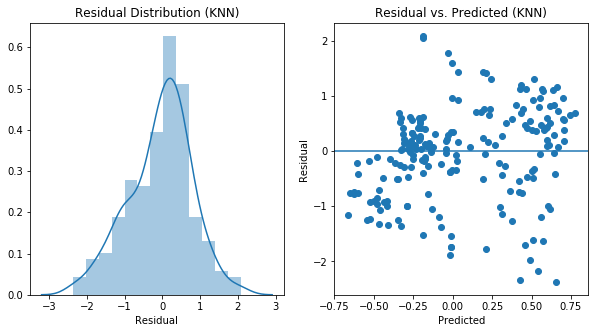

In [16]:
# Plot the residual distribution and the residual vs. predicted to check for error normality and homoscedasticity
knn_preds = knn.predict(X).ravel()
residual = Y - knn_preds

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.distplot(residual)
plt.title('Residual Distribution (KNN)')
plt.xlabel('Residual')

plt.subplot(1,2,2)
plt.scatter(knn_preds, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted (KNN)')
plt.show()

## Assumptions of Error Normality and Homoscedasticity

The Unweighted KNN and the OLS Regression model have relatively normal error distributions. The Weighted KNN has a huge spike in the center of its error distribution and miniscule, abnormal tails. All of the models are heteroscedastic to differing degrees. The weighted KNN appears to be overfit to the data except for a few outliers. The other two models seem to skew toward overestimating values for the outcome as the residual lean more negative the more greater the predicted value.

## Why the OLS Model is Relatively Better (but still awful)

The Ordinary Least Squares Model beats out the two KNN models here for model soundness, but not by much. Because nearly all of the assumptions made by a regression model when modeling are do not hold with this dataset, it is a poor choice for a regression model. Since this data is incredibly noisy, I think the unweighted KNN has no idea what value to predict when all the neighbors appear to be scattered at random. The weighted KNN has overfit the model because the distances of the neighboring points nullify their impact on the model. This leaves the rough generalization of a hyperplane from ordinary least squares regression conducted on all data points as the least bad of three terrible options.